# Active Learning Experiments

In [1]:
import matplotlib.pyplot as plt
#plt.style.use('seaborn-v0_8-pastel')
plt.style.use('bmh')
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
# plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['figure.facecolor'] = 'white'

plt.rcParams['lines.linewidth'] = 2
plt.rcParams["font.family"] = "serif"
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


## Approximation Expectation

In [6]:
import mlflow
import numpy as np
import pylab as plt
import pandas as pd

ds = 'letter'
client = mlflow.tracking.MlflowClient(tracking_uri=f'sqlite:////home/dhuseljic/mlflow/bait/{ds}_ablation_expectation.db')
experiment_id = client.get_experiment_by_name('Active Learning').experiment_id

# Food-101
# client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/food101')
# experiment_id = '270441571896962032'
runs = client.search_runs(experiment_ids=experiment_id)
print('Found {} experiments'.format(len(runs)))

Found 50 experiments


In [7]:
runs = []
init_query_list = [
    # "parameter.model.name = 'laplace_mlp'",
    "parameter.dino_model_name = 'dinov2_vits14'",
]
query_list = init_query_list + ["parameter.al.strategy = 'random'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'typiclust'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.expectation_topk = 'None'"] 
query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
query_list += ["parameter.al.bait.grad_likelihood = 'cross_entropy'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = 'full_' + r.data.params['al.strategy']
runs.extend(runs_)

for i in range(11):
    query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
    query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
    query_list += [f"parameter.al.bait.expectation_topk = '{i}'"] 
    query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
    query_list += ["parameter.al.bait.grad_likelihood = 'cross_entropy'"] 
    query = ' and '.join(query_list)
    runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
    for r in runs_:
        r.data.params['al.strategy'] = f'{r.data.params["al.bait.expectation_topk"]}' + '_ours'
    runs.extend(runs_)

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.expectation_topk = '1'"] 
query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
query_list += ["parameter.al.bait.grad_likelihood = 'cross_entropy_unbiased'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = f'{r.data.params["al.bait.expectation_topk"]}' + '_unbiased'
runs.extend(runs_)

# query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
# query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
# query_list += ["parameter.al.bait.expectation_topk = '1'"] 
# query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
# query_list += ["parameter.al.bait.grad_likelihood = 'cross_entropy'"] 
# query = ' and '.join(query_list)
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
# for r in runs_:
#     r.data.params['al.strategy'] = f'{r.data.params["al.bait.expectation_topk"]}' + r.data.params['al.strategy']
# runs.extend(runs_)

print('Found {} experiments'.format(len(runs)))

Found 50 experiments


In [8]:
al_strats = np.unique([run.data.params['al.strategy'] for run in runs])

learning_curves = {k: [] for k in al_strats}
query_times = {k: [] for k in al_strats}
num_samples = {k: [] for k in al_strats}

for run in runs:
    al_strat = run.data.params['al.strategy']
    # if "al.update_every" in run.data.params: continue
    acc_history = client.get_metric_history(run.info.run_id, 'accuracy')
    learning_curves[al_strat].append([metric.value for metric in acc_history])

    qtime_history = client.get_metric_history(run.info.run_id, 'query_time')
    query_times[al_strat].append([metric.value for metric in qtime_history][1:])

    num_init = int(run.data.params['al.num_init_samples'])
    num_acq = int(run.data.params['al.num_acq'])
    acq_size = int(run.data.params['al.acq_size'])
    num_samples[al_strat].append(range(num_init, num_init+num_acq*acq_size+1, acq_size))

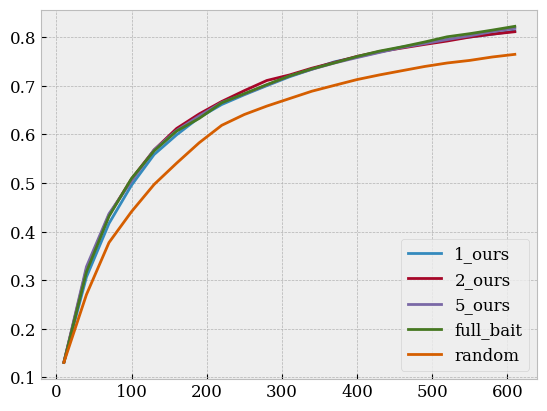

In [9]:
for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    lcs = [lc for lc in lcs if len(lc) > 20]
    # print([len(lc) for lc in lcs if len(lc)< ])

    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)
    plt.plot(axis, lc, label=al_strat)
    # plt.fill_between(axis, lc - std, lc + std, alpha=.3)

plt.legend()
plt.show()

1_ours 0.652321904791253
2_ours 0.6570399999973319
5_ours 0.6564685714031969
full_bait 0.6569504770849433
random 0.60722571387887


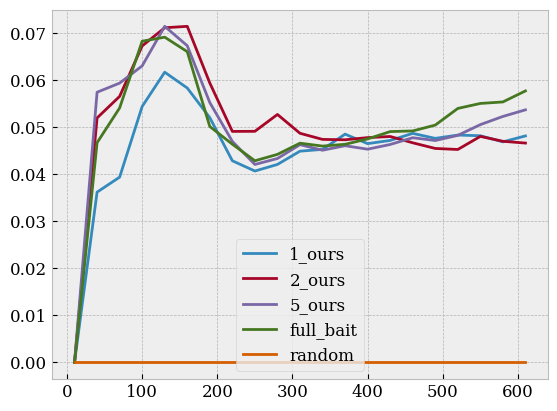

In [10]:
axis = np.mean(num_samples['random'], 0)
lc_random = np.mean(learning_curves['random'], 0)

for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    lcs = [lc for lc in lcs if len(lc) > 20 ]
    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)
    print(al_strat, np.mean(lc))

    plt.plot(axis, lc - lc_random, label=al_strat)
    # plt.fill_between(axis, lc - std, lc + std, alpha=.3)

plt.legend()
plt.show()

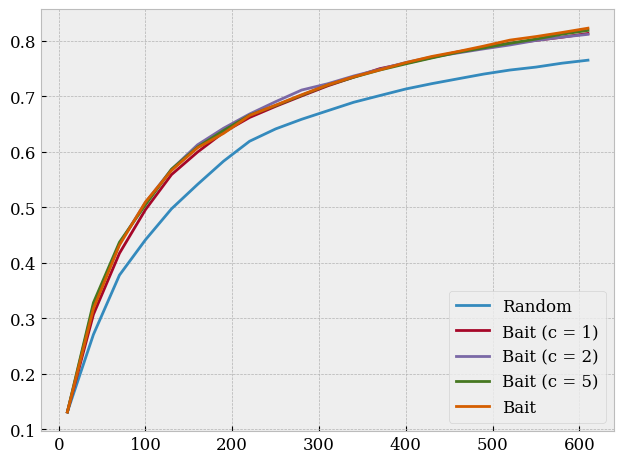

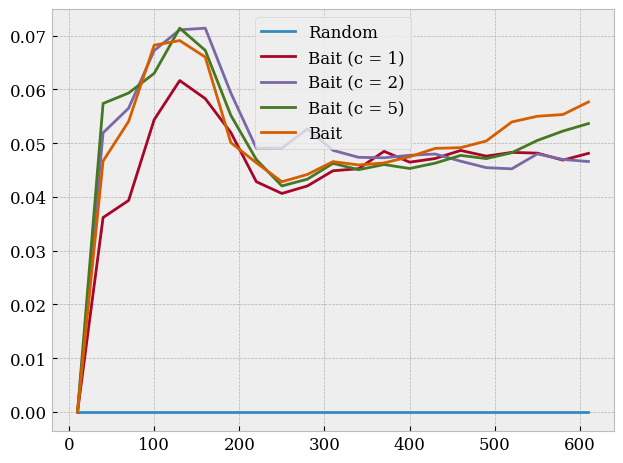

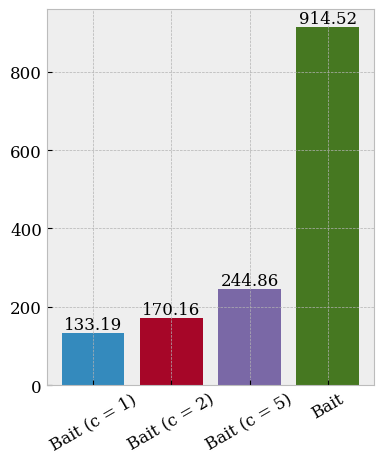

In [11]:
axis = np.mean(num_samples['random'], 0)
lc_random = np.mean(learning_curves['random'], 0)
    
plt.plot(axis, np.mean(learning_curves['random']  , axis=0), label='Random')
plt.plot(axis, np.mean(learning_curves['1_ours'] , axis=0), label='Bait (c = 1)')
plt.plot(axis, np.mean(learning_curves['2_ours'] , axis=0), label='Bait (c = 2)')
plt.plot(axis, np.mean(learning_curves['5_ours'], axis=0), label='Bait (c = 5)')
plt.plot(axis, np.mean(learning_curves['full_bait'], axis=0), label='Bait')

plt.tight_layout()
plt.legend()
plt.savefig('ablation_expectation_topc_lc.pdf')
plt.show()

axis = np.mean(num_samples['random'], 0)
lc_random = np.mean(learning_curves['random'], 0)
    
plt.plot(axis, np.mean(learning_curves['random'] -  lc , axis=0), label='Random')
plt.plot(axis, np.mean(learning_curves['1_ours'] - lc, axis=0), label='Bait (c = 1)')
plt.plot(axis, np.mean(learning_curves['2_ours'] - lc, axis=0), label='Bait (c = 2)')
plt.plot(axis, np.mean(learning_curves['5_ours'] - lc, axis=0), label='Bait (c = 5)')
plt.plot(axis, np.mean(learning_curves['full_bait'] - lc, axis=0), label='Bait')

plt.tight_layout()
plt.legend()
plt.savefig('ablation_expectation_topc_diff.pdf')
plt.show()

# plt.bar('Random', np.mean(query_times['random']))
plt.figure(figsize=(4, 4.8))
bars = []
bars.append(plt.bar('Bait (c = 1)', np.mean(query_times['1_ours'])))
bars.append(plt.bar('Bait (c = 2)', np.mean(query_times['2_ours'])))
bars.append(plt.bar('Bait (c = 5)', np.mean(query_times['5_ours'])))
bars.append(plt.bar('Bait', np.mean(query_times['full_bait'])))

for bar in bars:
    for rect in bar:
        x = rect.get_x() + rect.get_width() / 2
        height = rect.get_height()
        plt.text(x, height, f'{height:.2f}', ha='center', va='bottom')

plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('ablation_expectation_topc_time.pdf')
plt.show()

In [12]:
random_diff_auc = np.mean(learning_curves['random'], axis=0).mean()
data = [
    [np.mean(learning_curves[k], axis=0).mean()*100 for k in learning_curves],
    [(np.mean(learning_curves[k], axis=0).mean() - random_diff_auc)*100 for k in learning_curves],
    [np.mean(query_times[k]) for k in query_times],
]
df = pd.DataFrame(data, columns=learning_curves.keys(), index=['AUC', 'AUC (Performance Differences)', 'Acq Time'])
df = df[['random', '1_ours', '2_ours', '5_ours', 'full_bait']]
print(df.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrr}
\toprule
 & random & 1_ours & 2_ours & 5_ours & full_bait \\
\midrule
AUC & 60.72 & 65.23 & 65.70 & 65.65 & 65.70 \\
AUC (Performance Differences) & 0.00 & 4.51 & 4.98 & 4.92 & 4.97 \\
Acq Time & 0.00 & 133.19 & 170.16 & 244.86 & 914.52 \\
\bottomrule
\end{tabular}



## Gradient Likelihood

In [25]:
import mlflow
import numpy as np
import pylab as plt
import pandas as pd

dataset = 'snacks'
# client = mlflow.tracking.MlflowClient(tracking_uri=f'sqlite:////home/dhuseljic/mlflow/bait/{dataset}_ablation_likelihood.db')
client = mlflow.tracking.MlflowClient(tracking_uri=f'sqlite:////home/dhuseljic/mlflow/bait/{dataset}_benchmark.db')

experiment_id = client.get_experiment_by_name('Active Learning').experiment_id

# Food-101
# client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/food101')
# experiment_id = '270441571896962032'
runs = client.search_runs(experiment_ids=experiment_id)
print('Found {} experiments'.format(len(runs)))

Found 100 experiments


In [26]:
runs = []
init_query_list = [
    # "parameter.model.name = 'laplace_mlp'",
    "parameter.dino_model_name = 'dinov2_vits14'",
]
query_list = init_query_list + ["parameter.al.strategy = 'random'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.expectation_topk = 'None'"] 
query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
query_list += ["parameter.al.bait.grad_likelihood = 'cross_entropy'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = 'full_' + r.data.params['al.strategy']
runs.extend(runs_)

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'diag'"] 
query_list += ["parameter.al.bait.expectation_topk = 'None'"] 
query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
query_list += ["parameter.al.bait.grad_likelihood = 'cross_entropy'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = f'{r.data.params["al.bait.fisher_approximation"]}'
runs.extend(runs_)


query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.expectation_topk = 'None'"] 
query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
query_list += ["parameter.al.bait.grad_likelihood = 'binary_cross_entropy'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = f'{r.data.params["al.bait.grad_likelihood"]}'
runs.extend(runs_)

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.expectation_topk = '2'"] 
query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
query_list += ["parameter.al.bait.grad_likelihood = 'cross_entropy'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = f'{r.data.params["al.bait.expectation_topk"]}' + r.data.params['al.strategy']
runs.extend(runs_)

print('Found {} experiments'.format(len(runs)))

Found 50 experiments


In [27]:
al_strats = np.unique([run.data.params['al.strategy'] for run in runs])

learning_curves = {k: [] for k in al_strats}
query_times = {k: [] for k in al_strats}
num_samples = {k: [] for k in al_strats}

for run in runs:
    al_strat = run.data.params['al.strategy']
    # if "al.update_every" in run.data.params: continue
    acc_history = client.get_metric_history(run.info.run_id, 'accuracy')
    learning_curves[al_strat].append([metric.value for metric in acc_history])

    qtime_history = client.get_metric_history(run.info.run_id, 'query_time')
    query_times[al_strat].append([metric.value for metric in qtime_history][1:])

    num_init = int(run.data.params['al.num_init_samples'])
    num_acq = int(run.data.params['al.num_acq'])
    acq_size = int(run.data.params['al.acq_size'])
    num_samples[al_strat].append(range(num_init, num_init+num_acq*acq_size+1, acq_size))

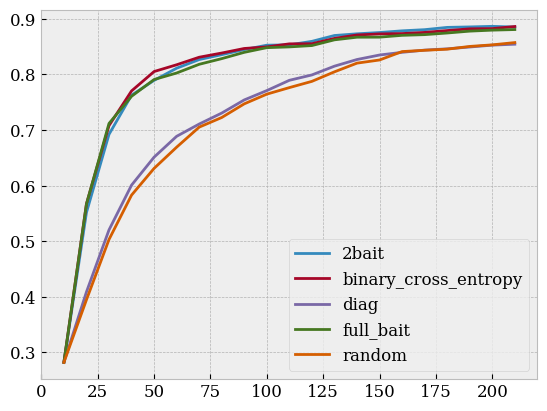

In [28]:
for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    lcs = [lc for lc in lcs if len(lc) > 20]
    # print([len(lc) for lc in lcs if len(lc)< ])

    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)
    plt.plot(axis, lc, label=al_strat)
    # plt.fill_between(axis, lc - std, lc + std, alpha=.3)

plt.legend()
plt.show()

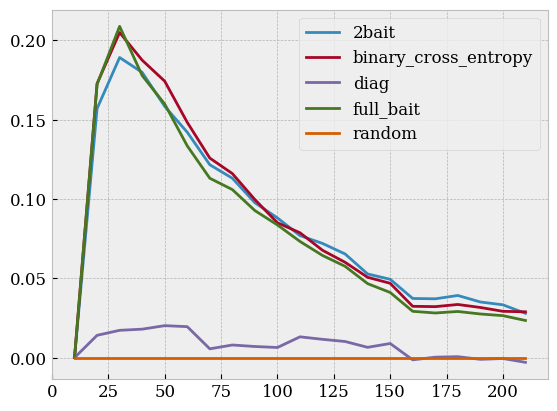

In [29]:
axis = np.mean(num_samples['random'], 0)
lc_random = np.mean(learning_curves['random'], 0)
lcs_random = learning_curves['random']

for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    lcs = [lc for lc in lcs if len(lc) > 20 ]
    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)

    plt.plot(axis, lc - lc_random, label=al_strat)

plt.legend()
plt.show()

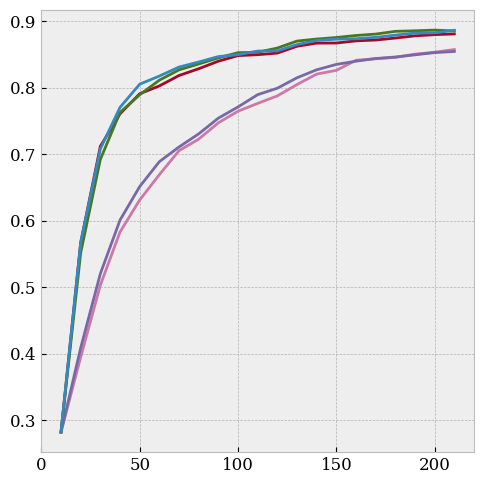

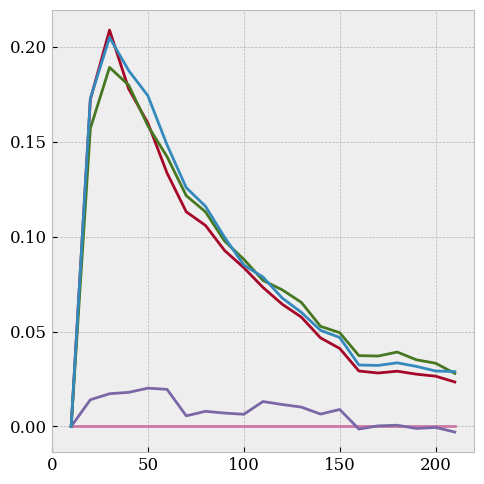

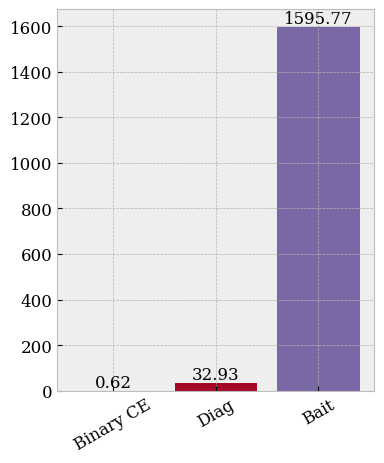

/tmp/ipykernel_3942756/3409451939.py:67: UserWarning: Glyph 9 (	) missing from current font.
  plt.savefig(f'legend.pdf', bbox_inches='tight', pad_inches=0)
/tmp/ipykernel_3942756/3409451939.py:67: UserWarning: Glyph 9 (	) missing from current font.
  plt.savefig(f'legend.pdf', bbox_inches='tight', pad_inches=0)
/home/dhuseljic/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


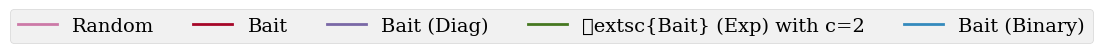

In [33]:
colors = {
    'random':       'C5',
    'full_bait':    'C1',
    'diag':         'C2',
    '2bait':        'C3',
    'bce':          'C0',
}
axis = np.mean(num_samples['random'], 0)
lc_random = np.mean(learning_curves['random'], 0)
    
plt.figure(figsize=(5, 5))
plt.plot(axis, np.mean(learning_curves['random']  , axis=0), label='Random', color=colors['random'])
plt.plot(axis, np.mean(learning_curves['full_bait'] , axis=0), label='Bait', color=colors['full_bait'])
plt.plot(axis, np.mean(learning_curves['diag'] , axis=0), label='Bait (Diag)', color=colors['diag'])
plt.plot(axis, np.mean(learning_curves['2bait'] , axis=0), label='Bait (c = 2)', color=colors['2bait'])
plt.plot(axis, np.mean(learning_curves['binary_cross_entropy'] , axis=0), label='Bait (Binary)', color=colors['bce'])

plt.tight_layout()
#plt.legend()
plt.savefig(f'ablation_likelihood_lc_{dataset}.pdf')
plt.show()

axis = np.mean(num_samples['random'], 0)
lc_random = np.mean(learning_curves['random'], 0)
    
plt.figure(figsize=(5, 5))
plt.plot(axis, np.mean(learning_curves['random'] -  lc_random , axis=0), label='Random', color=colors['random'])
plt.plot(axis, np.mean(learning_curves['full_bait'] - lc_random, axis=0), label='Bait', color=colors['full_bait'])
plt.plot(axis, np.mean(learning_curves['diag'] - lc_random, axis=0), label='Bait (Diag)', color=colors['diag'])
plt.plot(axis, np.mean(learning_curves['2bait'] - lc_random, axis=0), label='Bait (c = 2)', color=colors['2bait'])
plt.plot(axis, np.mean(learning_curves['binary_cross_entropy'] - lc_random, axis=0), label='Bait (Binary)', color=colors['bce'])

plt.tight_layout()
# plt.legend()
plt.savefig(f'ablation_likelihood_diff_{dataset}.pdf')
plt.show()

# plt.bar('Random', np.mean(query_times['random']))
plt.figure(figsize=(4, 4.8))
bars = []
bars.append(plt.bar('Binary CE', np.max(query_times['binary_cross_entropy'])))
bars.append(plt.bar('Diag', np.max(query_times['diag'])))
bars.append(plt.bar('Bait', np.max(query_times['full_bait'])))
# bars.append(plt.bar('Bait', np.mean(query_times['full_bait'])))

for bar in bars:
    for rect in bar:
        x = rect.get_x() + rect.get_width() / 2
        height = rect.get_height()
        plt.text(x, height, f'{height:.2f}', ha='center', va='bottom')

plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig(f'ablation_likelihood_time_{dataset}.pdf')
plt.show()

fig = plt.figure(figsize=(5, 5))
plt.plot(axis, np.mean(learning_curves['random']  , axis=0), label='Random', color=colors['random'])
plt.plot(axis, np.mean(learning_curves['full_bait'] , axis=0), label='Bait', color=colors['full_bait'])
plt.plot(axis, np.mean(learning_curves['diag'] , axis=0), label='Bait (Diag)', color=colors['diag'])
plt.plot(axis, np.mean(learning_curves['2bait'] , axis=0), label='Bait (Exp c=2) ', color=colors['2bait'])
plt.plot(axis, np.mean(learning_curves['binary_cross_entropy'] , axis=0), label='Bait (Binary)', color=colors['bce'])

plt.tight_layout()
plt.gca().set_visible(False)
fig.legend(loc='upper left', bbox_to_anchor = (0, .1, 1, 1), ncol=5, prop=dict(size=14))
plt.savefig(f'legend.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
random_diff_auc = np.mean(learning_curves['random'], axis=0).mean()
data = [
    [np.mean(learning_curves[k], axis=0).mean()*100 for k in learning_curves],
    [(np.mean(learning_curves[k], axis=0).mean() - random_diff_auc)*100 for k in learning_curves],
    [np.max(query_times[k]) for k in query_times],
]
df = pd.DataFrame(data, columns=learning_curves.keys(), index=['AUC', 'AUC (Performance Differences)', 'Acq Time'])
# df = df[['random','binary_cross_entropy', 'full_bait']]
df = df[['random', 'diag', 'binary_cross_entropy', 'full_bait']]
print(df.to_latex(float_format="+%.2f"))

\begin{tabular}{lrrrr}
\toprule
 & random & diag & binary_cross_entropy & full_bait \\
\midrule
AUC & +82.05 & +83.30 & +87.79 & +87.29 \\
AUC (Performance Differences) & +0.00 & +1.25 & +5.74 & +5.23 \\
Acq Time & +0.00 & +2.66 & +0.64 & +9.37 \\
\bottomrule
\end{tabular}



In [1]:
axis = np.mean(num_samples['random'], 0)
lc_random = np.mean(learning_curves['random'], 0)
lcs_random = learning_curves['random']

for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    lcs = [lc for lc in lcs if len(lc) > 20 ]
    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)

    plt.plot(axis, lc - lc_random, label=al_strat)

plt.legend()
plt.show()

NameError: name 'np' is not defined

## Benchmark

In [2]:
import mlflow
import numpy as np
import pylab as plt
import pandas as pd
# paper_style()

dataset = 'imagenet'
client = mlflow.tracking.MlflowClient(tracking_uri=f'sqlite:////home/dhuseljic/mlflow/bait/{dataset}_benchmark.db')
experiment_id = client.get_experiment_by_name('Active Learning').experiment_id

runs = client.search_runs(experiment_ids=experiment_id)
print('Found {} experiments'.format(len(runs)))

Found 50 experiments


In [3]:
runs = []
init_query_list = [
    "parameter.model.name = 'laplace'",
    "parameter.dino_model_name = 'dinov2_vits14'",
]
query_list = init_query_list + ["parameter.al.strategy = 'random'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'margin'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'badge'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'typiclust'"]
# query_list = init_query_list + ["parameter.al.subset_size = '15000'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.expectation_topk = '2'"] 
query_list += ["parameter.al.bait.grad_likelihood = 'cross_entropy'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = 'exp_' + r.data.params['al.strategy']
runs.extend(runs_)

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.expectation_topk = 'None'"] 
query_list += ["parameter.al.bait.grad_likelihood = 'binary_cross_entropy'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = 'bce_' + r.data.params['al.strategy']
runs.extend(runs_)

print('Found {} experiments'.format(len(runs)))

Found 50 experiments


In [4]:
al_strats = np.unique([run.data.params['al.strategy'] for run in runs])

learning_curves = {k: [] for k in al_strats}
query_times = {k: [] for k in al_strats}
num_samples = {k: [] for k in al_strats}

for run in runs:
    al_strat = run.data.params['al.strategy']
    # if "al.update_every" in run.data.params: continue
    acc_history = client.get_metric_history(run.info.run_id, 'accuracy')
    learning_curves[al_strat].append([metric.value for metric in acc_history])

    qtime_history = client.get_metric_history(run.info.run_id, 'query_time')
    query_times[al_strat].append([metric.value for metric in qtime_history][1:])

    num_init = int(run.data.params['al.num_init_samples'])
    num_acq = int(run.data.params['al.num_acq'])
    acq_size = int(run.data.params['al.acq_size'])
    num_samples[al_strat].append(range(num_init, num_init+num_acq*acq_size+1, acq_size))

for strat in learning_curves:
    print(strat, len(learning_curves[strat]))

badge 10
bce_bait 10
margin 10
random 10
typiclust 10


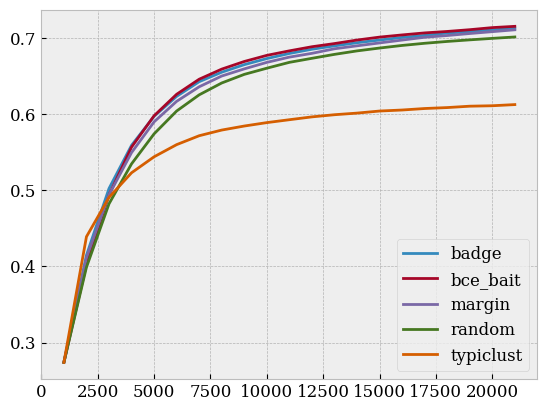

In [5]:
for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    lcs = [lc for lc in lcs if len(lc) > 20]
    # print([len(lc) for lc in lcs if len(lc)< ])

    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)
    plt.plot(axis, lc, label=al_strat)
    # plt.fill_between(axis, lc - std, lc + std, alpha=.3)

plt.legend()
plt.show()

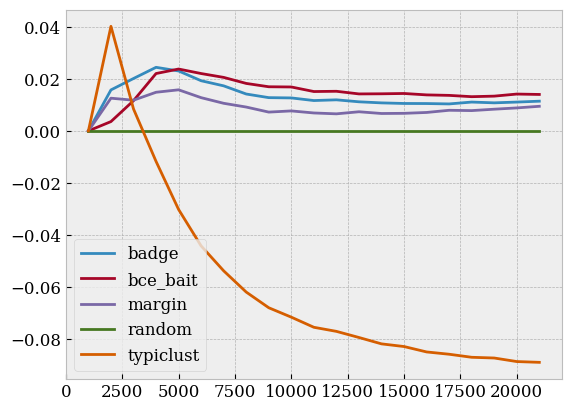

In [6]:
axis = np.mean(num_samples['random'], 0)
lc_random = np.mean(learning_curves['random'], 0)
lcs_random = learning_curves['random']

for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    lcs = [lc for lc in lcs if len(lc) > 20 ]
    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)

    plt.plot(axis, lc - lc_random, label=al_strat)

plt.legend()
plt.show()

In [17]:
random_diff_auc = np.mean(learning_curves['random'], axis=0).mean()
data = [
    [np.mean(learning_curves[k], axis=0).mean()*100 for k in learning_curves],
    [(np.mean(learning_curves[k], axis=0).mean() - random_diff_auc)*100 for k in learning_curves],
    # [np.mean(query_times[k]) for k in query_times],
]
columns = list(learning_curves.keys())
df = pd.DataFrame(data, columns=columns, index=['AUC', 'Diff'])
print(df)

# df = df[['random', 'margin', 'badge',  'bce_bait']]
df = df[['random', 'margin', 'badge', 'typiclust', 'bce_bait']]
# #df = df[['random', 'margin', 'badge', 'typiclust', 'exp_bait', 'bce_bait']]
print(df.to_latex(float_format="+%.2f"))

          badge   bce_bait     margin     random  typiclust
AUC   63.313733  63.457209  62.863086  61.978162  56.213733
Diff   1.335572   1.479048   0.884924   0.000000  -5.764428
\begin{tabular}{lrrrrr}
\toprule
 & random & margin & badge & typiclust & bce_bait \\
\midrule
AUC & +61.98 & +62.86 & +63.31 & +56.21 & +63.46 \\
Diff & +0.00 & +0.88 & +1.34 & +-5.76 & +1.48 \\
\bottomrule
\end{tabular}



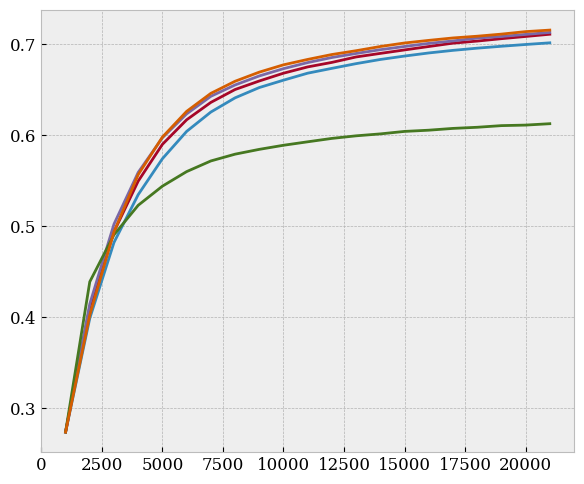

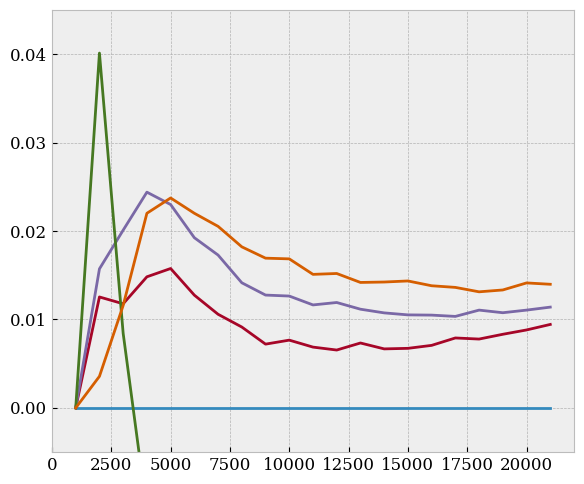

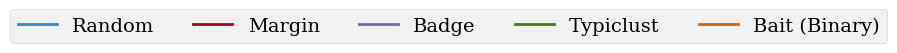

In [16]:
plt.figure(figsize=(6, 5))
axis = np.mean(num_samples['random'], axis=0)

plt.plot(axis, np.mean(learning_curves['random'], axis=0), label='Random')
plt.plot(axis, np.mean(learning_curves['margin'], axis=0), label='Margin')
plt.plot(axis, np.mean(learning_curves['badge'], axis=0), label='Badge')
plt.plot(axis, np.mean(learning_curves['typiclust'], axis=0), label='Typiclust')
plt.plot(axis, np.mean(learning_curves['bce_bait'], axis=0), label='Bait (Binary)')
# plt.plot(axis, np.mean(learning_curves['exp_bait'], axis=0), label='Bait (Exp)')
plt.tight_layout()
plt.savefig(f'{dataset}_benchmark_lc.pdf')


plt.figure(figsize=(6, 5))
lc_random = np.mean(learning_curves['random'], 0)
axis = np.mean(num_samples['random'], axis=0)
plt.plot(axis, np.mean(learning_curves['random'], axis=0) - lc_random, label='Random')
plt.plot(axis, np.mean(learning_curves['margin'], axis=0) - lc_random, label='Margin')
plt.plot(axis, np.mean(learning_curves['badge'], axis=0) - lc_random, label='Badge')
plt.plot(axis, np.mean(learning_curves['typiclust'], axis=0) - lc_random, label='Typiclust')
plt.plot(axis, np.mean(learning_curves['bce_bait'], axis=0) - lc_random, label='Bait (Binary)')
# plt.plot(axis, np.mean(learning_curves['exp_bait'], axis=0)- lc_random, label='Bait (Exp)')
plt.ylim((-0.005, 0.045))
plt.tight_layout()
plt.savefig(f'{dataset}_benchmark_lc_diff.pdf')

fig = plt.figure(figsize=(5, 5))
plt.plot(axis, np.mean(learning_curves['random'], axis=0) - lc_random, label='Random')
plt.plot(axis, np.mean(learning_curves['margin'], axis=0) - lc_random, label='Margin')
plt.plot(axis, np.mean(learning_curves['badge'], axis=0) - lc_random, label='Badge')
plt.plot(axis, np.mean(learning_curves['typiclust'], axis=0) - lc_random, label='Typiclust')
plt.plot(axis, np.mean(learning_curves['bce_bait'], axis=0) - lc_random, label='Bait (Binary)')
# plt.plot(axis, np.mean(learning_curves['exp_bait'], axis=0) - lc_random, label='Bait (Exp)')

plt.tight_layout()
plt.gca().set_visible(False)
fig.legend(loc='upper left', bbox_to_anchor = (0, .1, 1, 1), ncol=6, prop=dict(size=14))
plt.savefig(f'{dataset}_benchmark_legend.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

___

In [ ]:
# Summary of experiments
import mlflow
import numpy as np
import pylab as plt
import pandas as pd

image_datasets = ['cifar10', 'cifar100', 'imagenet']
text_datasets = []
tabular_datasets = ['letter', 'aloi']
datasets = image_datasets + text_datasets + tabular_datasets

for dataset in datasets:
    client = mlflow.tracking.MlflowClient(tracking_uri=f'sqlite:////home/dhuseljic/mlflow/bait/{dataset}_benchmark.db')
    experiment_id = client.get_experiment_by_name('Active Learning').experiment_id
    runs = client.search_runs(experiment_ids=experiment_id)
    al_strats = np.unique([run.data.params['al.strategy'] for run in runs], return_counts=True)
    print(f'Dataset: {dataset}')
    for strat, count in zip(*al_strats):
        print(f"\t Strategy: {strat} \t Reps: {count}")
    print('='* 30)



Dataset: cifar10
	 Strategy: badge 	 Reps: 10
	 Strategy: bait 	 Reps: 20
	 Strategy: margin 	 Reps: 10
	 Strategy: random 	 Reps: 10
	 Strategy: typiclust 	 Reps: 10
Dataset: cifar100
	 Strategy: badge 	 Reps: 10
	 Strategy: bait 	 Reps: 10
	 Strategy: margin 	 Reps: 10
	 Strategy: random 	 Reps: 10
	 Strategy: typiclust 	 Reps: 10
Dataset: imagenet
	 Strategy: badge 	 Reps: 10
	 Strategy: bait 	 Reps: 10
	 Strategy: margin 	 Reps: 10
	 Strategy: random 	 Reps: 10
	 Strategy: typiclust 	 Reps: 10
Dataset: letter
	 Strategy: badge 	 Reps: 10
	 Strategy: bait 	 Reps: 20
	 Strategy: margin 	 Reps: 10
	 Strategy: random 	 Reps: 10
	 Strategy: typiclust 	 Reps: 10
Dataset: aloi
	 Strategy: badge 	 Reps: 10
	 Strategy: bait 	 Reps: 20
	 Strategy: margin 	 Reps: 20
	 Strategy: random 	 Reps: 20


## Graphical Abstract

KeyError: 'badge'

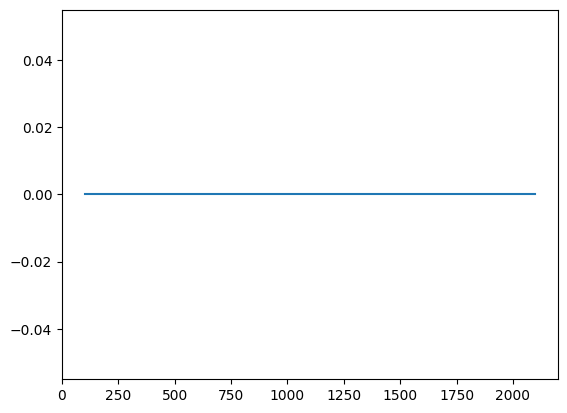

In [ ]:
mapping = {
    'random': 'Random', 
    'typiclust':'Typiclust', 
    'badge':'Badge', 
    'original_bait':'Bait', 
    'bait_binary_cross_entropy_None': 'Bait Approximation'
}

axis = np.mean(num_samples['random'], 0)
lc_random = np.mean(learning_curves['random'], 0)
    
plt.plot(axis, np.mean(learning_curves['random'], axis=0) - lc_random, label='Random')
plt.plot(axis, np.mean(learning_curves['badge'], axis=0) - lc_random, label='Badge')
plt.plot(axis, np.mean(learning_curves['typiclust'], axis=0) - lc_random, label='Typiclust')
plt.plot(axis, np.mean(learning_curves['original_bait'], axis=0) - lc_random, label='Bait')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig('graphical_abstract_a.pdf')
plt.show()

In [ ]:
al_strats = np.unique([run.data.params['al.strategy'] for run in runs])

query_times = {k: [] for k in al_strats}

for run in runs:
    al_strat = run.data.params['al.strategy']
    qtime_history = client.get_metric_history(run.info.run_id, 'query_time')
    query_times[al_strat].append([metric.value for metric in qtime_history][1:])

KeyError: 'badge'

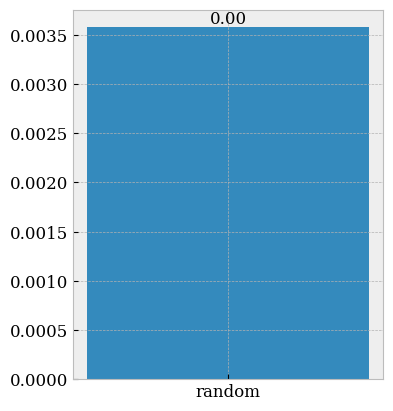

In [ ]:
from datetime import timedelta

plt.figure(figsize=(4, 4.8))
for strat in ['random', 'badge', 'typiclust', 'original_bait']:
    bar = plt.bar(strat, np.mean(query_times[strat]))

    for rect in bar:
        x = rect.get_x() + rect.get_width() / 2
        height = rect.get_height()
        plt.text(x, height, f'{height:.2f}', ha='center', va='bottom')


plt.gca().set_yscale('log')
plt.tight_layout()
plt.gca().xaxis.set_visible(False)

# plt.ylabel('Acquisition Time')
plt.savefig('graphical_abstract_b.pdf')
plt.show()

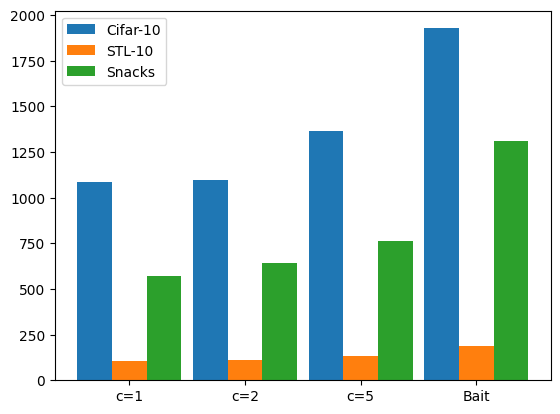

In [23]:
names = ['c=1', 'c=2', 'c=5', 'Bait']
acq_times_cifar10 = [1087.58, 1096.03, 1364.51, 1927.52]
acq_times_stl10 = [107.41, 109.81, 135.04, 190.1]
acq_times_snacks = [570.28, 640.73, 760.09, 1310.1]
x = np.arange(len(acq_times_cifar10))
w = .3


plt.bar(x - w, acq_times_cifar10, width=.3, label='Cifar-10')
plt.bar(x, acq_times_stl10, width=.3, label='STL-10')
plt.bar(x + w, acq_times_snacks, width=.3, label='Snacks')
plt.xticks(x, names)
plt.legend()